# PREPROCESAMIENTO

In [1]:
!pip install num2words
!pip install nltk
!pip install stop-words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5cefe224a2d78b7128485ae3ec84017d54057fb53f899b90681c119e6cb6babc
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=b384d400c907ce5df37e1ca29f47934e5b0cc5e6e797b64734c4cc96bd738fd2
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [2]:
import pandas as pd
import random
import numpy as np

from google.colab import drive
from google.colab import files

import matplotlib.pyplot as plt
import string

from num2words import num2words
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from collections import Counter
import unicodedata
import re

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.probability import FreqDist

from gensim.parsing.preprocessing import STOPWORDS


### PIPELINE

In [3]:
# Descarga de los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar el tokenizador, la lista de stopwords y el lematizador
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
sw_list = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def nltk_cleaner(text):
    clean_text = []

    # Eliminar etiquetas HTML usando BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Eliminar caracteres especiales usando expresiones regulares
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Eliminar acentos, etc
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Separar palabras eliminando signos de puntuación
    for word in tokenizer.tokenize(text):
        # Eliminar stop words
        if word not in sw_list:
            # Eliminar espacios sobrantes, convertir a minúsculas y lematizar
            clean_word = lemmatizer.lemmatize(word).lower().strip()
            # Convertir dígitos a palabras
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')
            clean_text.append(clean_word)

    return ' '.join(clean_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
# Esta función me permite agrupar las estrellas para luego realizar el analisis de sentimiento.

def label_sentiment(row):
    if int(row['overall']) < 4:
        return 0
    else:
        return 1

In [5]:
# Creo una funcion para balancear los sentimientos y me quedo con 50000 reviews

def filter_df(df):
    filtered_dfs = []

    for value in df['sentiment'].unique():
        filtered_df = df[df['sentiment'] == value].head(50000)
        filtered_dfs.append(filtered_df)

    df = pd.concat(filtered_dfs)

    return df

In [6]:
# Aplico stopWords de la libreria Gensim

def remove_stopwords_gensim(sentence):
    sw_list = STOPWORDS
    sentence = ' '.join([word for word in sentence.split() if word not in sw_list])
    return sentence

In [7]:
# Eliminación de palabras poco informativas

def remove_words(text, words_to_remove):
    text = ' '.join([word for word in text.split() if word not in words_to_remove])
    return text


In [8]:
# Conecto al drive y guardo el archivo

drive.mount('/content/drive')

music_df = pd.read_csv('/content/drive/MyDrive/music_df_full.csv')

Mounted at /content/drive


In [9]:
# Comprobamos que se haya descargado correctamente

music_df.shape

(1512530, 2)

In [10]:
# Eliminamos los valores nulos

music_df.dropna(subset=['overall', 'reviewText'], inplace=True)
music_df.reset_index(drop=True, inplace=True)

In [11]:
# Obtenemos una lista de todas las palabras únicas en 'reviewText'

unique_words = set()

for review in music_df['reviewText']:
    words = review.split()
    unique_words.update(words)

# Convertimos el conjunto de palabras únicas de nuevo a una lista
vocabulario = list(unique_words)

print("Cantidad de palabras únicas en el vocabulario:", len(vocabulario))
print("Primeras 10 palabras del vocabulario:", vocabulario[:10])

Cantidad de palabras únicas en el vocabulario: 911430
Primeras 10 palabras del vocabulario: ['(Music123)', 'sanitizer', 'promo/discount', 'descent).', 'keynote', 'using???', 'Off/Once/Daily', 'L/R.', 'MKII."', 'Albarn...dont']


In [12]:
# Aplico la función de unificación de reviews y creo una columna "sentiment".

music_df['sentiment'] = music_df.apply(lambda row: label_sentiment(row), axis=1)
music_df.head(10)

,overall,reviewText,sentiment
0,5,Crocheting for Dummies by Karen Manthey & Susa...,1
1,4,Very helpful...,1
2,5,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1
3,4,My girlfriend use quite often,1
4,5,Arrived as described. Very happy.,1
5,5,Love the Dummies Series. Never fails.,1
6,5,Good book.,1
7,4,Just started reading it. Love the charts & cau...,1
8,4,GREAT book,1
9,5,this is a very helpful book.,1


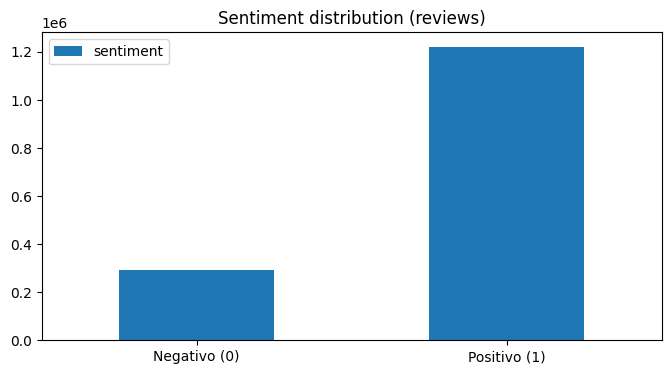

In [13]:
# Observamos el desbalance de sentimientos.

aux_df = pd.DataFrame(music_df['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (reviews)', figsize=(8, 4))
aux_df.set_xticklabels(['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.show()

Considerando el desbalance del sentimiento de 5 estrellas respecto a las demas estrellas que se observa en el primer notebook y con la necesidad de reducir el tamaño de reviews para ejecutarlo en Colab; llamo a la función filter_df.

In [14]:
# Llamar a la función df para quedarnos solamente con 50000 reviews de cada sentimiento

music_df = filter_df(music_df)

In [15]:
# Aqui compruebo que la se aplica bien la funcion para que el analisis este equilibrado

counts = music_df['sentiment'].value_counts()
print(counts)

1    50000
0    50000
Name: sentiment, dtype: int64


In [16]:
# Aplicar la función nltk_cleaner

music_df['review_clean'] = music_df['reviewText'].apply(nltk_cleaner)

<ipython-input-3-69c561955078>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-3-69c561955078>:16: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [17]:
music_df.head(20)

,overall,reviewText,sentiment,review_clean
0,5,Crocheting for Dummies by Karen Manthey & Susa...,1,crocheting dummies karen manthey susan brittai...
1,4,Very helpful...,1,very helpful
2,5,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1,easy to understand and a prompt service too
3,4,My girlfriend use quite often,1,my girlfriend use quite often
4,5,Arrived as described. Very happy.,1,arrived described very happy
5,5,Love the Dummies Series. Never fails.,1,love dummies series never fails
6,5,Good book.,1,good book
7,4,Just started reading it. Love the charts & cau...,1,just started reading love chart caution
8,4,GREAT book,1,great book
9,5,this is a very helpful book.,1,helpful book


Como podemos ver, luego de realizar una limpieza y la eliminacion de stopwords, todavia hay limpieza por hacer.


In [18]:
# Aplicar la función remove_stopwords

music_df['review_norm'] = music_df['review_clean'].apply(remove_stopwords_gensim)

In [19]:
music_df.head(20)

,overall,reviewText,sentiment,review_clean,review_norm
0,5,Crocheting for Dummies by Karen Manthey & Susa...,1,crocheting dummies karen manthey susan brittai...,crocheting dummies karen manthey susan brittai...
1,4,Very helpful...,1,very helpful,helpful
2,5,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1,easy to understand and a prompt service too,easy understand prompt service
3,4,My girlfriend use quite often,1,my girlfriend use quite often,girlfriend use
4,5,Arrived as described. Very happy.,1,arrived described very happy,arrived described happy
5,5,Love the Dummies Series. Never fails.,1,love dummies series never fails,love dummies series fails
6,5,Good book.,1,good book,good book
7,4,Just started reading it. Love the charts & cau...,1,just started reading love chart caution,started reading love chart caution
8,4,GREAT book,1,great book,great book
9,5,this is a very helpful book.,1,helpful book,helpful book


En general, parece que hemos conseguido un buen preprocesamiento del texto. Sin embargo, es importante tener en cuenta que la efectividad del preprocesamiento puede variar según el contexto y los requisitos específicos de cada análisis. Por lo que se observa, la columna review_norm se ajusta a mis expectativas de preprocesamiento, pero realizare un análisis de n-grams para ver si quedan palabras por eliminar.






In [20]:
# Realizo una simple comparativa de una review para ver el proceso de normalización

print('Review original: {}'.format(music_df['reviewText'].values[120]))
print('Review procesada: {}'.format(music_df['review_norm'].values[120]))

Review original: This book is a good book, but I am dyslexic and generally can't comprehend learning from a book to weel. I did share it with my sister.
Review procesada: book good book dyslexic generally comprehend learning book weel share sister


In [21]:
# Ahora eliminamos las columnas que no necesitamos para nuestro análisis

music_df = music_df[['sentiment', 'review_norm']]

### N-grams mas frecuentes

In [22]:
# Aqui expandimos la columna en una serie de palabras separadas

words = music_df['review_norm'].str.split().apply(pd.Series).stack().reset_index(drop = True)

<ipython-input-22-ff0d8d85e1fd>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words = music_df['review_norm'].str.split().apply(pd.Series).stack().reset_index(drop = True)


In [23]:
# Contamos las palabras de nuestro vocabulario

vocabulary_ = Counter(words)
len(vocabulary_)

57092

In [24]:
# N-grams mas frecuentes

bigrams_freq_ = FreqDist(ngrams(words, 2))
trigrams_freq_ = FreqDist(ngrams(words, 3))

In [25]:
bigrams_freq_.most_common(30)

[(('work', 'great'), 1845),
 (('sound', 'quality'), 1757),
 (('sound', 'great'), 1734),
 (('sound', 'good'), 1521),
 (('good', 'quality'), 1508),
 (('dont', 'know'), 1440),
 (('year', 'old'), 1296),
 (('great', 'product'), 1273),
 (('sound', 'like'), 1247),
 (('great', 'price'), 1158),
 (('acoustic', 'guitar'), 1100),
 (('work', 'fine'), 1037),
 (('great', 'sound'), 1027),
 (('im', 'sure'), 1006),
 (('look', 'like'), 955),
 (('waste', 'money'), 940),
 (('good', 'price'), 936),
 (('year', 'ago'), 935),
 (('highly', 'recommend'), 932),
 (('feel', 'like'), 920),
 (('easy', 'use'), 914),
 (('long', 'time'), 897),
 (('works', 'great'), 852),
 (('les', 'paul'), 837),
 (('good', 'sound'), 836),
 (('good', 'product'), 814),
 (('music', 'store'), 807),
 (('high', 'quality'), 799),
 (('pretty', 'good'), 794),
 (('doesnt', 'work'), 791)]

In [26]:
trigrams_freq_.most_common(30)

[(('local', 'music', 'store'), 312),
 (('dont', 'waste', 'money'), 292),
 (('high', 'e', 'string'), 216),
 (('epiphone', 'les', 'paul'), 165),
 (('great', 'product', 'great'), 151),
 (('year', 'old', 'son'), 144),
 (('year', 'old', 'daughter'), 135),
 (('sound', 'quality', 'good'), 126),
 (('bought', 'year', 'ago'), 122),
 (('sound', 'pretty', 'good'), 122),
 (('playing', 'guitar', 'year'), 121),
 (('bought', 'year', 'old'), 115),
 (('low', 'e', 'string'), 112),
 (('dont', 'waste', 'time'), 110),
 (('great', 'sound', 'great'), 107),
 (('gibson', 'les', 'paul'), 107),
 (('great', 'price', 'great'), 103),
 (('waste', 'time', 'money'), 100),
 (('e', 'string', 'broke'), 99),
 (('great', 'sound', 'quality'), 95),
 (('product', 'great', 'price'), 94),
 (('good', 'sound', 'quality'), 93),
 (('string', 'sound', 'great'), 92),
 (('ive', 'playing', 'guitar'), 89),
 (('work', 'like', 'charm'), 83),
 (('learn', 'play', 'guitar'), 82),
 (('highly', 'recommend', 'product'), 80),
 (('built', 'like', 

Podemos observar que todavía falta limpieza para mejorar mi vocabulario ya que hay muchas palabras que no aportaran nada a nuestro análisis.

In [27]:
# Cuento cuantas filas hay vacias de cada sentimiento.

empty_rows_sentiment_0 = music_df[music_df['sentiment'] == 0]['review_norm'].str.strip().eq('').sum()
empty_rows_sentiment_1 = music_df[music_df['sentiment'] == 1]['review_norm'].str.strip().eq('').sum()

print("Número de filas vacías en 'review_norm' para sentiment 0:", empty_rows_sentiment_0)
print("Número de filas vacías en 'review_norm' para sentiment 1:", empty_rows_sentiment_1)

Número de filas vacías en 'review_norm' para sentiment 0: 55
Número de filas vacías en 'review_norm' para sentiment 1: 105


In [28]:
# Ejemplo de palabras poco informativas para eliminar vistas en los n-grams
words_to_remove = {'e', 'im','les', 'paul','year','ago','ive','sure','product','time','long','son','daughter','dont'}

# Aplica la eliminación de palabras
music_df['review_norm'] = music_df['review_norm'].apply(remove_words, words_to_remove=words_to_remove)

In [29]:
# Cuento cuantas filas tengo vacia de cada sentimiento

empty_sentiment_0 = music_df[music_df['sentiment'] == 0]['review_norm'].str.strip().eq('').sum()
empty_sentiment_1 = music_df[music_df['sentiment'] == 1]['review_norm'].str.strip().eq('').sum()

print("Número de filas vacías para sentiment 0:", empty_sentiment_0)
print("Número de filas vacías para sentiment 1:", empty_sentiment_1)

Número de filas vacías para sentiment 0: 61
Número de filas vacías para sentiment 1: 119


In [30]:
# Ahora elimino las filas vacias asumiendo un pequeño desbalance de sentimiento

music_df['review_norm'] = music_df['review_norm'].replace('', np.nan)
music_df_process = music_df.dropna(subset=['review_norm'])

In [31]:
music_df_process.shape

(99820, 2)

In [32]:
music_df_process.head()

,sentiment,review_norm
0,1,crocheting dummies karen manthey susan brittai...
1,1,helpful
2,1,easy understand prompt service
3,1,girlfriend use
4,1,arrived described happy


In [33]:
# Ahora descargo el dataframe para realizar el preprocesamiento en otro notebook.

music_df_process.to_csv('/content/drive/MyDrive/music_df_process.csv', index=False)

Conclusion: He realizado un analisis de las reviews y utilizando la libreria NLTK he realizado una limpieza, pero como he comentado en el notebook, se observa que no ha sido suficiente por lo que aplico stopwords de la libreria Gensim para mejorar la limpieza de los datos. Luego utilicé una función para seguir limpiando palabras especificas que he observado con los n-grams. Entiendo que se podria realizar una mejor limpieza de los datos con mayor tiempo de exploración y mejor entendimiento de las palabras, quizas con la libreria Spacy en vez de NLTK pero como no es un trabajo para producción, he elegido esa libreria para limpieza.